In [2]:
%matplotlib inline
import pyfits as fits
import numpy as np
from fancy_plot import *
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d
import os
MJDREF = 51910.0 + 7.428703703703703E-4
print MJDREF

@np.vectorize
def MET_to_MJD(met_time):
    return met_time/86400.+MJDREF

@np.vectorize
def MJD_to_MET(mjd_time):
    return (mjd_time - MJDREF)*86400.

@np.vectorize
def delta_psi(theta1,phi1, theta2, phi2):
    sp = np.sin(theta1)*np.cos(phi1)*np.sin(theta2)*np.cos(phi2) \
         + np.sin(theta1)*np.sin(phi1)*np.sin(theta2)*np.sin(phi2) \
         +np.cos(theta1)*np.cos(theta2)
    return np.arccos(sp)
    
MET_to_MJD(519492965)
MJD_to_MET(56000)

51910.0007429


array(353375935.81600016)

In [4]:
data = fits.open('./data/L18032713221998FEC74D57_PH00.fits')
print data

[<pyfits.hdu.image.PrimaryHDU object at 0x108937f90>, <pyfits.hdu.table.BinTableHDU object at 0x1086ded90>, <pyfits.hdu.table.BinTableHDU object at 0x10893f210>]


In [5]:
z = data[1].data

In [6]:
start_t = MET_to_MJD(data[1].header['TSTART'])
stop_t = MET_to_MJD(data[1].header['TSTOP'])
print start_t
print stop_t

#Kloppo (MJD :56819.20)
# dec_min=9.
# dec_max=13.
# ra_min=108.
# ra_max=113.
# mjd_min = 58000
# mjd_max = 58090

# #IceCube171106 (MJD :58063.77753472)
# dec_min=5.
# dec_max=9.
# ra_min=338.
# ra_max=342.


dec_min=3.7
dec_max=7.5
ra_min=74.
ra_max=80.
start_t = 56902
stop_t = 56922

# mjd_min = 56000
# mjd_max = 56100

# mjd_min = 56950
# mjd_max = 57050

# mjd_min = 57950
# mjd_max = 58050


# mjd_min = 56900
# mjd_max = 57100

56850.0007776
57150.0007776


MJD: 56902.0 - 56922
saved as MJD_pc_56902_56922_E_11_188.png


KeyboardInterrupt: 

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


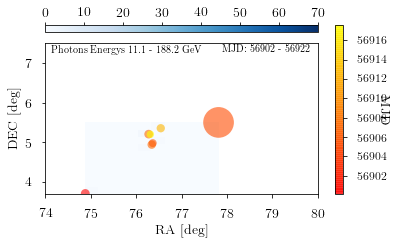

In [7]:
t_run = float(start_t)
while t_run < float(stop_t):
    mjd_min = t_run
    if t_run + 100 < stop_t:    
        mjd_max = t_run + 100
    else:
        mjd_max = stop_t
    print('MJD: {} - {}'.format(mjd_min, mjd_max))
    mask = (z['ENERGY']>10000)&\
           (MET_to_MJD(z['TIME'])>mjd_min)&\
           (MET_to_MJD(z['TIME'])<mjd_max)&\
           (z['DEC']>dec_min)&\
           (z['DEC']<dec_max)&\
           (z['RA']>ra_min) &\
           (z['RA']<ra_max)
    plot_data = z[mask]

    fig, ax = newfig(0.9)
    cm = plt.cm.get_cmap('autumn')
    sort_ind = np.argsort(plot_data['ENERGY']/10**2.7)
    plot_data = plot_data[sort_ind[::-1]]
    if not len(plot_data)>0:
        t_run += 100
        continue
    MJD_time = MET_to_MJD(plot_data['TIME'])
    sc = ax.scatter(plot_data['RA'],plot_data['DEC'], c=MJD_time,
                    s=plot_data['ENERGY']/10**2.3, 
                    zorder = 1 , cmap=cm,
                    alpha = 0.6, lw = 0)
    # plt.scatter(77.36,5.69, zorder = 10, facecolors='none', edgecolors='black', s= 300)
    plt.grid(True)
    cbar = fig.colorbar(sc)
    cbar.ax.set_yticklabels(['{:.0f}'.format(x) for x in np.linspace(np.min(MJD_time), np.max(MJD_time), 10)],
                            fontsize=12,
                            weight='bold')
    cbar.ax.set_ylabel('MJD', rotation=270)
    plt.text(0.02, 0.95,'Photons Energys {:.1f} - {:.1f} GeV'.format(np.min(plot_data['ENERGY'])/1000.,
                                                           np.max(plot_data['ENERGY'])/1000.),
             horizontalalignment='left',
             verticalalignment='center',
             transform = ax.transAxes,
             weight='bold' , zorder = 3)
    plt.text(0.97, 0.95,'MJD: {:.0f} - {:.0f}'.format(mjd_min,mjd_max),
             horizontalalignment='right',
             verticalalignment='center',
             transform = ax.transAxes,
             weight='bold', zorder = 3)
    ###### Background
    H, xedges, yedges = np.histogram2d(plot_data['RA'],plot_data['DEC'],bins=(10,10))
    X, Y = np.meshgrid(xedges,yedges)
    sc2 = ax.pcolormesh(X, Y, H.T,
                        cmap=plt.get_cmap('Blues'),
                        zorder = 0,
                        vmin=0, vmax=70)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top",size="5%", pad=0.15)
    fig.add_axes(cax)
    cbar2 = fig.colorbar(sc2, cax=cax, orientation="horizontal")
    cbar2.ax.xaxis.set_ticks_position('top')
    cbar2.ax.xaxis.set_tick_params(pad=2.0)
    ax.set_xlabel('RA [deg]')
    ax.set_ylabel('DEC [deg]')

    #### EHE Contour
    contour_path = '../IC_170922/contour_90.npy'
    if os.path.exists(contour_path):
        contour = np.load(contour_path)
        ax.plot(np.concatenate(contour[:,0:1]),
                np.concatenate(contour[:,1:2]),
                zorder=2, color='k',
                linestyle='--')



    filename = 'MJD_pc_{:.0f}_{:.0f}_E_{:.0f}_{:.0f}.png'.format(mjd_min,
                                                          mjd_max,
                                                          np.min(plot_data['ENERGY'])/1000.,
                                                          np.max(plot_data['ENERGY'])/1000.)
    print('saved as {}'.format(filename))
    ax.set_xlim(ra_min,ra_max)
    ax.set_ylim(dec_min, dec_max)
    t_run += 100
    savepath = './TXS/Bruno/'
    if not os.path.exists(savepath):
        os.makedirs(savepath)
    plt.savefig(os.path.join(savepath, filename), dpi=300)
    plt.show()

# Energy Lightcurve

In [8]:
color = ['blue', 'red']

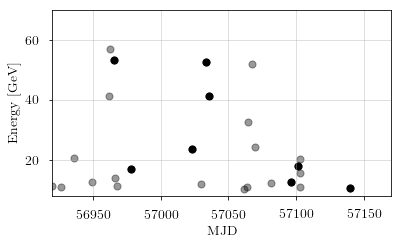

In [55]:
positions=[(77.36,5.69)]#,(76.35,05.00)]
fig, ax = newfig(0.9)
for i, position in enumerate(positions):
    ra = position[0]
    dec = position[1]
    ang_dist = np.degrees(delta_psi(np.radians(z['DEC']),
                                    np.radians(z['RA']),
                                    np.radians(dec),
                                    np.radians(ra)))
    psf_mask68 = [ang_dist[j]<(10**psf68(np.log10(en))) for j, en in enumerate(z['ENERGY'])]
    psf_mask95 = [ang_dist[j]<(10**psf95(np.log10(en))) for j, en in enumerate(z['ENERGY'])]
    mask68 = (psf_mask68) & (z['ENERGY']>10000)
    mask95 = (psf_mask95) & (z['ENERGY']>10000)
    x_val = MET_to_MJD(z['TIME'])
    ax.scatter(x_val[mask95], (z['ENERGY']/1000.)[mask95], alpha = 0.4, color='k', s=50)
    ax.scatter(x_val[mask68], (z['ENERGY']/1000.)[mask68], alpha = 1., color='k', s=50)
    
ax.set_xlim(56920, 57170)
ax.set_ylim(8.0,70)
ax.set_xlabel('MJD')
ax.set_ylabel('Energy [GeV]')
plt.grid(True)
plt.savefig('lightcurve.png', dpi=300)
plt.show()

# Fermi PSF

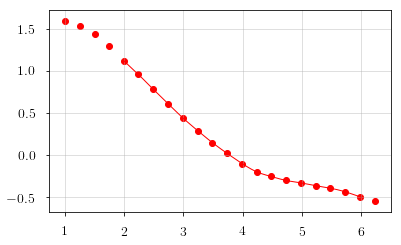

In [47]:
psf_data = np.genfromtxt('./data/PSF90.csv', delimiter=',')
fig, ax = newfig(0.9)
en = np.concatenate(psf_data[:,0:1])
res = np.concatenate(psf_data[:,1:2])
plt.scatter(np.log10(en), np.log10(res))
psf95 = interp1d(np.log10(en), np.log10(res), kind='cubic')
x = np.linspace(1e2, 1e6, 10000)
plt.plot(np.log10(x),psf95(np.log10(x)))
plt.grid(True)

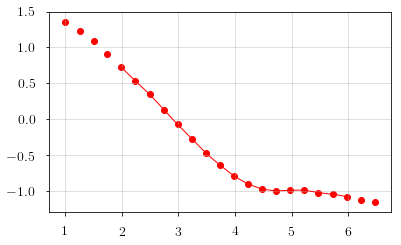

In [48]:
psf_data = np.genfromtxt('./data/PSF68.csv', delimiter=',')
fig, ax = newfig(0.9)
en = np.concatenate(psf_data[:,0:1])
res = np.concatenate(psf_data[:,1:2])
plt.scatter(np.log10(en), np.log10(res))
psf68 = interp1d(np.log10(en), np.log10(res), kind='cubic')
x = np.linspace(1e2, 1e6, 10000)
plt.plot(np.log10(x),psf68(np.log10(x)))
plt.grid(True)

# Exposure Map

In [157]:
exposure = fits.open('./TXS_region_unbin_exp_map.fits')

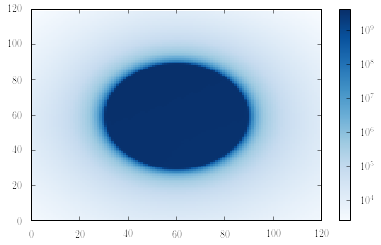

In [174]:
fig, ax = newfig(0.9)
# H, xedges, yedges = np.histogram2d(z['RA'],z['DEC'],bins=(50,50))
X, Y = np.meshgrid(range(120),range(120))
z = exposure[0].data[2]
cbar = ax.pcolormesh(X, Y, z,
                     cmap=plt.get_cmap('Blues'),
                     norm=colors.LogNorm(vmin=z.min(), vmax=z.max()))
 # x- und y-Skala im gleichen Maßstaab
plt.colorbar(cbar)
plt.show()